<a href="https://colab.research.google.com/github/Logeshwari-2001/Anomaly/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
import sys

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print("pandas : {0}".format(pd.__version__))
print("numpy : {0}".format(np.__version__))
print("matplotlib : {0}".format(matplotlib.__version__))
print("seaborn : {0}".format(sns.__version__))
print("sklearn : {0}".format(sklearn.__version__))
print("imblearn : {0}".format(imblearn.__version__))


pandas : 1.5.3
numpy : 1.22.4
matplotlib : 3.7.1
seaborn : 0.12.2
sklearn : 1.2.2
imblearn : 0.10.1


In [2]:
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

# Load NSL_KDD train dataset
train = pd.read_csv("/content/KDDTrain.csv", names=datacols) # change path to where the dataset is located.
test = pd.read_csv("/content/KDDTest.csv", names=datacols)
#eliminating the unwanted extra field
train = train.iloc[:,:-1]
test = test.iloc[:,:-1]
     

In [3]:
print(train.head(4))

print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  \
0               0       0    0                  0          0                0   
1               0       0    0                  0          0                0   
2               0       0    0                  0          0                0   
3               0       0    0                  0          1                0   

   root_shell  su_attempted  num_root  num_file_creations  num_shells  \
0           0             0         0                   0           0   
1           0             0         0                   0           0   
2           0 

In [4]:
print(test.head(4))

print("Training data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp   private  REJ          0          0     0   
1         0           tcp   private  REJ          0          0     0   
2         2           tcp  ftp_data   SF      12983          0     0   
3         0          icmp     eco_i   SF         20          0     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  \
0               0       0    0                  0          0                0   
1               0       0    0                  0          0                0   
2               0       0    0                  0          0                0   
3               0       0    0                  0          0                0   

   root_shell  su_attempted  num_root  num_file_creations  num_shells  \
0           0             0         0                   0           0   
1           0             0         0                   0           0   
2           0 

In [5]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [6]:
train['attack'] = train['attack'].apply(lambda v: mapping[v])
test['attack'] = test['attack'].apply(lambda v: mapping[v])

In [7]:
attack_class_freq_train = train[['attack']].apply(lambda x: x.value_counts())

attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_dist = pd.concat([attack_class_freq_train], axis=1) 
attack_class_dist

,attack,frequency_percent_train
Normal,67343,53.46
DoS,45927,36.46
Probe,11656,9.25
R2L,995,0.79
U2R,52,0.04


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))

cols = test.select_dtypes(include=['float64','int64']).columns
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()


# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)


# separate target column from encoded data 
enctrain = traincat.drop(['attack'], axis=1)
cat_Ytrain = traincat[['attack']].copy()



In [20]:
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train['attack']
train_x.shape




(22544, 41)

In [24]:
train_y
y_train=train.attack




0           DoS
1           DoS
2        Normal
3         Probe
4         Probe
          ...  
22539    Normal
22540    Normal
22541       DoS
22542    Normal
22543     Probe
Name: attack, Length: 22544, dtype: object


In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, y_train, test_size=0.2, random_state=42)


ValueError: ignored

In [59]:
accuracy_dict = {}

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
for feature in X_train.columns:
    # Fit a rfc model using cross-validation to choose the optimal hyperparameters
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(rfc, X_train[[feature]], y_train, cv=5)
    accuracy = scores.mean()
    # Evaluate the performance of the model on the validation set
    rfc.fit(X_train[[feature]], y_train)
    y_pred = rfc.predict(X_test[[feature]])
    accuracy_dict[feature] = accuracy_score(y_test, y_pred)

# Print the accuracy scores for each feature
for feature, accuracy in accuracy_dict.items():
    print(feature, ':', accuracy)

duration : 0.5355824568366739
src_bytes : 0.9262552093669378
dst_bytes : 0.8128993847985712
land : 0.5327644373883708
wrong_fragment : 0.5417741615399881
urgent : 0.5327247469736058
hot : 0.5405040682675134
num_failed_logins : 0.5326056757293114
logged_in : 0.7372891446715618
num_compromised : 0.5387973804326255
root_shell : 0.5327247469736058
su_attempted : 0.5327247469736058
num_root : 0.532685056558841
num_file_creations : 0.532685056558841
num_shells : 0.5326453661440762
num_access_files : 0.5327247469736058
num_outbound_cmds : 0.5327247469736058
is_host_login : 0.5327247469736058
is_guest_login : 0.5327247469736058
count : 0.8045247072831911
srv_count : 0.6258781504266719
serror_rate : 0.8126215518952173
srv_serror_rate : 0.8010319507838857
rerror_rate : 0.5862274260766025
srv_rerror_rate : 0.5668188132565986
same_srv_rate : 0.8494145663822187
diff_srv_rate : 0.8641397102599723
srv_diff_host_rate : 0.5535225243103791
dst_host_count : 0.6729906727525302
dst_host_srv_count : 0.79916

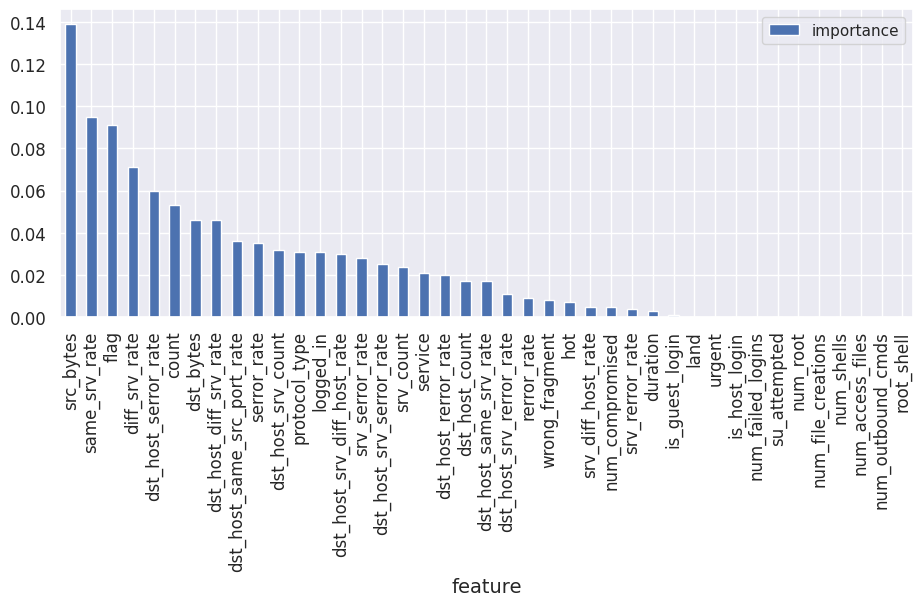

In [12]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

SELECTING THE IMPORTANT FEATURES

In [15]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'count',
 'srv_count',
 'serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'protocol_type',
 'service',
 'flag']

In [31]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

TRAINING THE MODEL

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

# instantiate the model (using the default parameters)

svm_model = SVC(kernel='rbf', C=10, gamma=0.1,random_state=0)
svm_model.fit(X_train_rfe, y_train)
logreg = LogisticRegression(n_jobs=-1,random_state=0)
logreg.fit(X_train_rfe, y_train)


LogisticRegression(n_jobs=-1, random_state=0)

In [62]:
svm_iterations = svm_model.n_iter_
print(svm_iterations)

[9440 2440  709  693 4574 2643  566  974  806  170]


In [63]:
log_iterations = logreg.n_iter_
print(log_iterations)

[100]


THRESHOLD VALUES FOR EACH FEATURE

In [34]:
thresholds = {}
normal_indices = y == 'Normal'
for feature in train_x.columns:
    feature_values = train_x.loc[:, feature]
    feature_normal_values = feature_values[normal_indices]
    threshold = feature_normal_values.max()
    thresholds[feature] = threshold

# Print the threshold value for each feature
for feature, threshold in thresholds.items():
    print(f'{feature}: {threshold:.2f}')

duration: 15.44
src_bytes: 15.25
dst_bytes: 1.74
land: 70.98
wrong_fragment: -0.09
urgent: 208.82
hot: 35.72
num_failed_logins: 88.39
logged_in: 1.24
num_compromised: 312.37
root_shell: 27.28
su_attempted: 44.27
num_root: 306.06
num_file_creations: 88.83
num_shells: 90.15
num_access_files: 90.53
num_outbound_cmds: 0.00
is_host_login: 354.93
is_guest_login: 10.25
count: 3.73
srv_count: 6.65
serror_rate: 1.60
srv_serror_rate: 1.61
rerror_rate: 2.75
srv_rerror_rate: 2.72
same_srv_rate: 0.77
diff_srv_rate: 5.20
srv_diff_host_rate: 3.47
dst_host_count: 0.73
dst_host_srv_count: 1.26
dst_host_same_srv_rate: 1.07
dst_host_diff_srv_rate: 4.85
dst_host_same_src_port_rate: 2.76
dst_host_srv_diff_host_rate: 8.59
dst_host_serror_rate: 1.61
dst_host_srv_serror_rate: 1.62
dst_host_rerror_rate: 2.87
dst_host_srv_rerror_rate: 2.75
protocol_type: 2.00
service: 65.00
flag: 10.00


In [35]:
coef = logreg.coef_.ravel()
intercept = logreg.intercept_

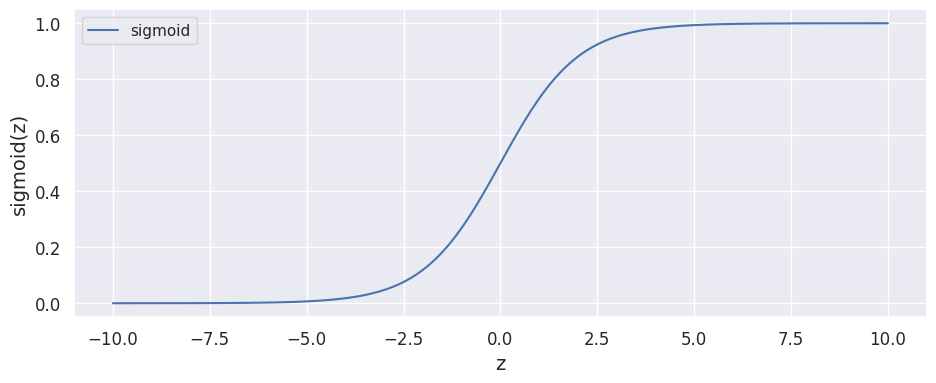

In [36]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# plot logistic function
z = np.linspace(-10, 10, 1000)

# Load learned coefficients from logistic regression
weights = logreg.coef_[0]
intercept = logreg.intercept_[0]

# Calculate linear combination of input features and coefficients
z_pred = np.dot(X_train_rfe, weights) + intercept

# Calculate predicted probabilities using sigmoid function
y_pred_proba = sigmoid(z_pred)

# Plot sigmoid curve
plt.plot(z, sigmoid(z), 'b-', label='sigmoid')

plt.xlabel('z')
plt.ylabel('sigmoid(z)')
plt.legend(loc='best')
plt.show()

In [37]:
import pickle
with open('svm_model1.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

In [33]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
y_train_pred = svm_model.predict(X_train_rfe)
accuracy_svm = accuracy_score(y_train, y_train_pred)
print(accuracy_svm)
cm_train = metrics.confusion_matrix(y_train, y_train_pred)
print(cm_train)

0.9848974974696858
[[35952   785     9     0     0]
 [   32 53567   185   135     2]
 [   18    79  9202     0     0]
 [    0   250     0   520     1]
 [    0    22     0     4    15]]


In [58]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
y_test_pred = svm_model.predict(X_test_rfe)
accuracy_svm2 = accuracy_score(y_test, y_test_pred)
print("Accuracy of SVM",accuracy_svm2)
cm_train2 = metrics.confusion_matrix(y_test, y_test_pred)
print(cm_train2)

Accuracy of SVM 0.9825362175034729
[[ 8987   188     6     0     0]
 [   15 13295    66    46     0]
 [    8    31  2318     0     0]
 [    0    69     0   154     1]
 [    0     5     0     5     1]]


In [48]:
confusion_matrix_5x5 = [[ 8987 ,  188 ,    6   ,  0  ,   0],
 [   15 ,13295 ,   66  ,  46 ,    0],
 [    8  ,  31 , 2318    , 0    , 0],
 [    0 ,   69,     0,   154 ,    1],
 [    0 ,    5,     0,     5,     1]]


confusion_matrix_2x2 = [[confusion_matrix_5x5[0][0], sum(confusion_matrix_5x5[0][1:])], 
                       [sum([row[0] for row in confusion_matrix_5x5[1:]]), 
                        sum([item for sublist in confusion_matrix_5x5 for item in sublist]) - confusion_matrix_5x5[0][0] - sum(confusion_matrix_5x5[0][1:])]]

#print(confusion_matrix_2x2)
lst = [[8987, 194], [23, 16014]]
mtx = np.array(lst)

print(mtx)

[[ 8987   194]
 [   23 16014]]


In [42]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
y_train_pred = logreg.predict(X_train_rfe)
accuracy_svm = accuracy_score(y_train, y_train_pred)
print(accuracy_svm)
cm_train = metrics.confusion_matrix(y_train, y_train_pred)
print(cm_train)

0.9315624441842466
[[34685  1717   344     0     0]
 [  558 51607  1756     0     0]
 [  164  1546  7589     0     0]
 [    6   756     9     0     0]
 [    2    31     8     0     0]]


In [57]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
y_test_pred = logreg.predict(X_test_rfe)
accuracy_logreg = accuracy_score(y_test, y_test_pred)
print("Accuracy of Logistic Regression: ",accuracy_logreg)
cm_train2 = metrics.confusion_matrix(y_test, y_test_pred)
print(cm_train2)

Accuracy of Logistic Regression:  0.9310577495534829
[[ 8658   433    90     0     0]
 [  129 12846   447     0     0]
 [   34   369  1954     0     0]
 [    2   220     2     0     0]
 [    0     9     2     0     0]]


In [46]:
confusion_matrix_5x5 = [[43304,  2489,  134,  0,    0],
                        [648,   64695, 1991, 9,    0],
                        [179,   2277,  9200, 0,    0],
                        [15,    921,   59,   0,    0],
                        [2,     32,    18,   0,    0]]
confusion_matrix_2x2 = [[confusion_matrix_5x5[0][0], sum(confusion_matrix_5x5[0][1:])], 
                       [sum([row[0] for row in confusion_matrix_5x5[1:]]), 
                        sum([item for sublist in confusion_matrix_5x5 for item in sublist]) - confusion_matrix_5x5[0][0] - sum(confusion_matrix_5x5[0][1:])]]
print(confusion_matrix_2x2)

[[43304, 2623], [844, 80046]]


In [51]:
confusion_matrix_5x5 = [[ 8658 ,  433,    90,     0 ,    0],
 [  129, 12846 ,  447 ,    0  ,   0],
 [   34 ,  369  ,1954  ,   0   ,  0],
 [    2  , 220   ,  2   ,  0    , 0],
 [    0   ,  9    , 2    , 0     ,0]]
confusion_matrix_2x2 = [[confusion_matrix_5x5[0][0], sum(confusion_matrix_5x5[0][1:])], 
                       [sum([row[0] for row in confusion_matrix_5x5[1:]]), 
                        sum([item for sublist in confusion_matrix_5x5 for item in sublist]) - confusion_matrix_5x5[0][0] - sum(confusion_matrix_5x5[0][1:])]]
#print(confusion_matrix_2x2)

lst = [[8658, 523], [165, 16014]]
mtx = np.array(lst)

print(mtx)

[[ 8658   523]
 [  165 16014]]
